In [1]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [2]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [3]:
ground_truth[8]

{'question': 'Where can I find the office hours sessions?',
 'course': 'machine-learning-zoomcamp',
 'document': '39fda9f0'}

In [4]:
doc_idx = {d['id']: d for d in documents}

In [5]:
doc_idx['c02e79ef']['text']

"The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel."

## Index data
We'll generate embeddings using the sentence transformers library, if you don't have it, install it with pip:

pip install sentence-transformers
This is a different way of turning sentences into vectors

In [6]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from tqdm.auto import tqdm

vectors = []

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    vector = model.encode(question + ' ' + text)
    vectors.append(vector)

  0%|                                                                                   | 0/948 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|█████████████████████████████████████████████████████████████████████████| 948/948 [00:56<00:00, 16.88it/s]


In [8]:
import numpy as np

vectors = np.array(vectors)

In [9]:
from minsearch import VectorSearch

vindex = VectorSearch(keyword_fields=['course'])
vindex.fit(vectors, documents)

## Retrieval

In [10]:
def minsearch_vector_search(vector, course):
    return vindex.search(
        vector,
        filter_dict={'course': course},
        num_results=5
    )

def question_text_vector(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return minsearch_vector_search(v_q, course)

In [11]:
question_text_vector(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'section': 'General course-related questions',
  'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'id': '5170565b'},
 {'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'section': 'General course-related questions',
  'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'id': '39fda9f0'},
 {'text': "Problem description\nThe accuracy and the loss are both still the same or nearly the same while training.\nSol

## The RAG Flow

In [12]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [13]:
from ratelimit import limits, sleep_and_retry
from google import genai

gg_client = genai.Client()

@sleep_and_retry
@limits(calls=10, period=60)
def llm(prompt, model="gemini-2.5-flash"):
    response = gg_client.models.generate_content(
    model=model,
    contents=prompt
    )

    return response.text

In [14]:
def rag(query: dict, model="gemini-2.5-flash") -> str:
    search_results = question_text_vector(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt)

    return answer

In [15]:
#Test on ground truth set
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [16]:
rag(ground_truth[10])

/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


"Yes, everything is recorded, so you won't miss anything. The course videos are pre-recorded, and the office hours sessions (live sessions) are also recorded."

In [17]:
doc_idx['5170565b']

{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'section': 'General course-related questions',
 'question': 'What if I miss a session?',
 'course': 'machine-learning-zoomcamp',
 'id': '5170565b'}

## Cosine Similarity Metric

In [18]:
answer_org = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'
answer_llm = "Yes, everything is recorded, so you won't miss anything. This includes the pre-recorded course videos and the live office hours sessions."

v_org = model.encode(answer_org)
v_llm = model.encode(answer_llm)

v_org.dot(v_llm)

/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


np.float32(0.64593995)

In [19]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [20]:
# @sleep_and_retry
# @limits(calls=8, period=60)
# def rag_limited(rec):
#     return rag(rec)

# answers = {}

# for i, rec in enumerate(tqdm(ground_truth)):
#     if i in answers:
#         continue
    
#     answer_llm = rag_limited(rec)
#     doc_id = rec['document']
#     original_doc = doc_idx[doc_id]
#     answer_ori = original_doc['text']

#     answers[i] = {
#         'answer_llm': answer_llm,
#         'answer_ori': answer_ori,
#         'document': doc_id,
#         'question': rec['question'],
#         'course': rec['course']
#     }

In [21]:
answers = {}

In [23]:
import pandas as pd
df_gpt4o = pd.read_csv('data/results-gpt4o.csv')
df_gpt4o.head()

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


## Cosine Similarity

In [26]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [27]:
record = results_gpt4o[0]

In [33]:
def compute_similarity(record):
    answer_org = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_org = model.encode(answer_org)
    v_llm = model.encode(answer_llm)
    
    return v_org.dot(v_llm)

In [34]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|                                                                                  | 0/1830 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████| 1830/1830 [02:50<00:00, 10.72it/s]


In [35]:
df_gpt4o['cosine'] = similarity

In [38]:
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [39]:
import seaborn as sns

<Axes: xlabel='cosine', ylabel='Count'>

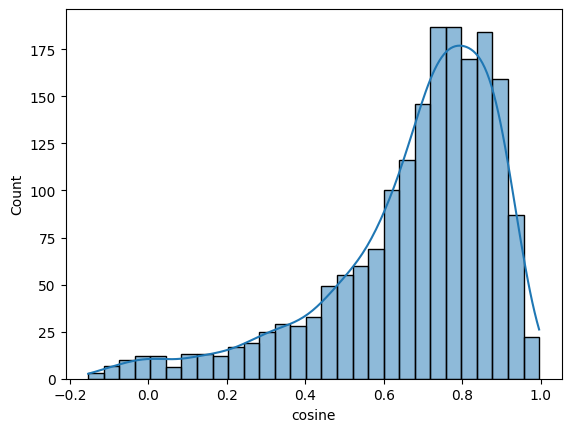

In [42]:
sns.histplot(df_gpt4o['cosine'],kde=True)